# Creating and Valuing a CDS Option

Example CDS Valuation and comparison with market standard ISDA model on Markit website

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from financepy.finutils import *
from financepy.products.libor import *
from financepy.products.credit import *

####################################################################
# FINANCEPY BETA Version 0.180 - This build:  22 Sep 2020 at 22:29 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#    For bug reports and comments - allmypythonprojects@gmail.com  #
####################################################################



Set the trade date and settlement date one day later

In [2]:
tradeDate = FinDate(5, 2, 2014)
settlementDate = tradeDate.addDays(1)

## Build Libor Curve

In [3]:
depos = []
dcType = FinDayCountTypes.THIRTY_E_360
fixedFreq = FinFrequencyTypes.SEMI_ANNUAL
swapType = FinLiborSwapTypes.PAYER
swap1 = FinLiborSwap(settlementDate,"1Y",swapType,0.0502,fixedFreq,dcType)
swap2 = FinLiborSwap(settlementDate,"2Y",swapType,0.0502,fixedFreq,dcType)
swap3 = FinLiborSwap(settlementDate,"3Y",swapType,0.0501,fixedFreq,dcType)
swap4 = FinLiborSwap(settlementDate,"4Y",swapType,0.0502,fixedFreq,dcType)
swap5 = FinLiborSwap(settlementDate,"5Y",swapType,0.0501,fixedFreq,dcType)
swaps = [swap1,swap2,swap3,swap4,swap5]

liborCurve = FinLiborCurve(settlementDate, depos, [], swaps)

## Build a CDS Curve

In [4]:
cdsFlatSpread = 0.0100

In [6]:
cds1 = FinCDS(settlementDate, "1Y", cdsFlatSpread)
cds2 = FinCDS(settlementDate, "2Y", cdsFlatSpread)
cds3 = FinCDS(settlementDate, "3Y", cdsFlatSpread)
cds4 = FinCDS(settlementDate, "4Y", cdsFlatSpread)
cds5 = FinCDS(settlementDate, "5Y", cdsFlatSpread)
cds6 = FinCDS(settlementDate, "7Y", cdsFlatSpread)
cds7 = FinCDS(settlementDate, "10Y", cdsFlatSpread)
cds8 = FinCDS(settlementDate, "15Y", cdsFlatSpread)

In [7]:
cdss = [cds1, cds2, cds3, cds4, cds5, cds6, cds7, cds8]

In [8]:
recoveryRate = 0.40

In [9]:
issuerCurve = FinCDSCurve(settlementDate, cdss, liborCurve, recoveryRate)

## CDS Option

In [10]:
stepInDate = tradeDate.addDays(1)
valuationDate = stepInDate
expiryDate = FinDate(20, 3, 2014)
maturityDate = FinDate(20, 6, 2019)    

In [11]:
cdsCoupon = 0.01
volatility = 0.3    
notional = ONE_MILLION
longProtection = True

In [12]:
strikes = np.linspace(80,120,21)/10000
longValues = []
shortValues = []

# Long Protection
for strike in strikes:
    cdsOption = FinCDSOption(expiryDate, maturityDate, strike, notional, True)
    v = cdsOption.value(valuationDate, issuerCurve, volatility)
    longValues.append(v)
    
# Short Protection
for strike in strikes:
    cdsOption = FinCDSOption(expiryDate, maturityDate, strike, notional, False)
    v = cdsOption.value(valuationDate, issuerCurve, volatility)
    shortValues.append(v)
    

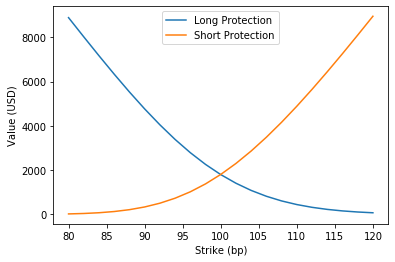

In [14]:
plt.plot(strikes*10000, longValues, label="Long Protection")
plt.plot(strikes*10000, shortValues, label="Short Protection")
plt.xlabel("Strike (bp)")
plt.ylabel("Value (USD)")
plt.legend();

## Put Call Parity

Check that put-call parity holds by comparing a long protection minus a short protection option to a forward starting long protection CDS

In [15]:
fwdValues = []

for strike in strikes:
    fwdCDSContract = FinCDS(expiryDate, maturityDate, strike, notional, True)
    v = fwdCDSContract.value(valuationDate, issuerCurve, recoveryRate)
    fwdValues.append(v['full_pv'])

In [16]:
callMinusPut = np.array(longValues) - np.array(shortValues)

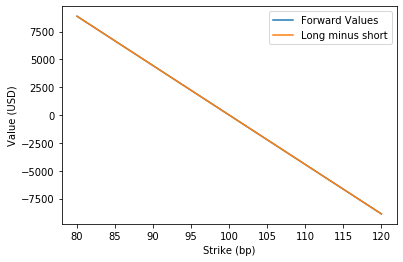

In [17]:
plt.plot(strikes*10000, fwdValues, label="Forward Values")
plt.plot(strikes*10000, callMinusPut, label="Long minus short")
plt.xlabel("Strike (bp)")
plt.ylabel("Value (USD)")
plt.legend()

## Implied Volatility

Let us just check that we can recover the input volatility

In [25]:
for strike in np.linspace(100, 200, 21):
    cdsOption = FinCDSOption(expiryDate, maturityDate, strike / 10000.0,  notional, False)
    v = cdsOption.value(valuationDate, issuerCurve, volatility)
    vol = cdsOption.impliedVolatility(valuationDate, issuerCurve, v)
    print("%10d %12.5f %12.8f%%" %(strike, v, vol*100))

       100   1803.97332  30.00000000%
       105   3167.72741  30.00000000%
       110   4887.68461  30.00000000%
       115   6851.33951  30.00000000%
       120   8954.96897  30.00000000%
       125  11127.58625  30.00000000%
       130  13329.93441  30.00000000%
       135  15543.66858  30.00000000%
       140  17761.33222  30.00000000%
       145  19980.23291  30.00000000%
       150  22199.49266  30.00000000%
       155  24418.84940  30.00000000%
       160  26638.23073  30.00000000%
       165  28857.61795  30.00000000%
       170  31077.00651  30.00000000%
       175  33296.39537  30.00000000%
       180  35515.78428  30.00000000%
       185  37735.17321  30.00000000%
       190  39954.56214  30.00000000%
       195  42173.95108  30.00000000%
       200  44393.34001  30.00000000%


We recovery the used volatility as required.

Copyright (c) 2020 Dominic O'Kane